# Customer Churn Prediction with PySpark



In [2]:
# import libraries

import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when, collect_list
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [3]:
# create a Spark session
spark = SparkSession \
.builder \
.appName('CustomerChurn') \
.getOrCreate()

23/06/09 16:51:20 WARN Utils: Your hostname, Mohils-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.8 instead (on interface en0)
23/06/09 16:51:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/09 16:51:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1686343881232'),
 ('spark.driver.port', '57934'),
 ('spark.app.id', 'local-1686343882435'),
 ('spark.driver.host', '192.168.0.8'),
 ('spark.executor.id', 'driver'),
 ('spark.app.submitTime', '1686343881070'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security

In [5]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# 2. Data Understanding


### Explore Data

In [6]:
df.limit(5).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Column types 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [9]:
# Shape of the smaller Sparkify dataframe
nrows = df.count()
ncols = len(df.dtypes)
print(f'The imported dataframe has {nrows} rows and {ncols} columns.')

The imported dataframe has 286500 rows and 18 columns.


In [10]:
# Obtain the number of distinct users in the smaller Sparkify dataset
df.select(['userId']).dropDuplicates().count()

226

In [11]:
# drop duplicates method would identify inconsistent number of unique users.
df.select(['firstName','gender','lastName','location','registration','userAgent','userId']) \
.where(df.userId != "") \
.dropDuplicates().count()

225

In [12]:
# Number of sessions
df.select("sessionId").dropDuplicates().count()

2354

In [13]:
# There are also no empty strings in the column
df.where(df.sessionId == "").count()

0

In [14]:
#SessionId is a unique identifier only for a specific user. Multiple users can have sessions labelled with the
#same sessionId
df.where(df.userId != "")\
.select(['userId','sessionId']).dropDuplicates()\
.groupby('sessionId').count().sort('count', ascending = False).show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|      112|    4|
|      110|    4|
|      113|    4|
|       54|    4|
|      167|    4|
+---------+-----+
only showing top 5 rows



In [15]:
# Sessions in the dataset can be very long.
session_end = df.where(df.userId != "") \
.groupby(['userId','sessionId']).agg(Fmax('ts').alias('max'), 
                                     Fmin('ts').alias('min'), 
                                     ((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
.sort('sessionlength', ascending = False).show(5)

+------+---------+-------------+-------------+-------------+
|userId|sessionId|          max|          min|sessionlength|
+------+---------+-------------+-------------+-------------+
|    91|     1840|1542852334000|1542585029000|     267305.0|
|   115|      316|1538924417000|1538701498000|     222919.0|
|   101|      635|1539263366000|1539065365000|     198001.0|
|   120|      731|1539793336000|1539630700000|     162636.0|
|    61|      529|1539247693000|1539096212000|     151481.0|
+------+---------+-------------+-------------+-------------+
only showing top 5 rows



In [16]:
#In the provided dataset the maximum interval is 3310 seconds which is around 55 minutes.
windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
df = df.withColumn("diff", (df.ts - df.previousts)/1000)
df.where(df.userId != "").agg(Fmax(col('diff'))).show()

+---------+
|max(diff)|
+---------+
|   3310.0|
+---------+



In [17]:
# Number of different artists
df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()

17655

In [18]:
# There are rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

8346

In [19]:
# The subscription 'level' variable in the dataset is largely independent of other variables. 
#Users have the flexibility to switch between the free and premium tiers at any moment. 
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [20]:
# Print first 5 rows to get the idea of the dataframe; first 11 columns in alphabetical order
df.select(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName','length', 'level', 'location', 'method', 'page']).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|
+----------------+------

In [21]:
# Print first 5 rows to get the idea of the dataframe; 12.-18. column
df.select(['registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']).show(5)

+-------------+---------+--------------------+------+-------------+--------------------+------+
| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+--------------------+------+-------------+--------------------+------+
|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [22]:
# Explore missing values in the 'userId' column
df.where(df.userId.isNull()).count()

0

### User-level Analysis 

In [23]:
# Logs belonging to a specific user
df.where(df.userId == 4).select(['userId','sessionId','itemInSession','auth','level','page','ts']).show(20)

+------+---------+-------------+---------+-----+--------+-------------+
|userId|sessionId|itemInSession|     auth|level|    page|           ts|
+------+---------+-------------+---------+-----+--------+-------------+
|     4|      240|            0|Logged In| free|NextSong|1538356650000|
|     4|      240|            1|Logged In| free|  Logout|1538356651000|
|     4|      240|            4|Logged In| free|    Home|1538356686000|
|     4|      240|            5|Logged In| free|NextSong|1538356889000|
|     4|      240|            6|Logged In| free|    Home|1538356954000|
|     4|      240|            7|Logged In| free|NextSong|1538357110000|
|     4|      240|            8|Logged In| free|NextSong|1538357328000|
|     4|      240|            9|Logged In| free|NextSong|1538357543000|
|     4|      240|           10|Logged In| free|NextSong|1538357746000|
|     4|      240|           11|Logged In| free|NextSong|1538357996000|
|     4|      240|           12|Logged In| free|NextSong|1538358

In [24]:
# Rows with empty string in the 'userId' column correspond to logs in which user has not been logged in
# (either 'Logged Out' or 'Guest' authentication levels). 
df.select(['userId','firstName','gender','lastName',
           'sessionId','location','auth','level','ts','page']).where(df.userId == "").show(10)

df.where(df.userId == "").groupby('auth').count().show()

+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|userId|firstName|gender|lastName|sessionId|location|      auth|level|           ts| page|
+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355745000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355807000| Help|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355841000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355842000|Login|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356678000| Home|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356679000|Login|
|      |     null|  null|    null|      100|    null|Logged Out| free|1538358102000|Login|
|      |     null|  null|    null|      241|    null|Logged Out| free|1538360117000|Login|

In [25]:
# Explore the auth column

df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
| Logged In|278102|
|     Guest|    97|
+----------+------+



In [26]:
#App users dataset
gender_dist = df.select(['userId','gender']).where(df.userId != "").dropDuplicates(['userId']).groupby('gender').count().toPandas()
gender_dist_rel = (gender_dist.set_index('gender') / sum(gender_dist['count']))

#Activity dataset
gender_dist_logs = df.where(df.userId != "").groupby('gender').count().toPandas()
gender_dist_logs_rel = (gender_dist_logs.set_index('gender') / sum(gender_dist_logs['count']))

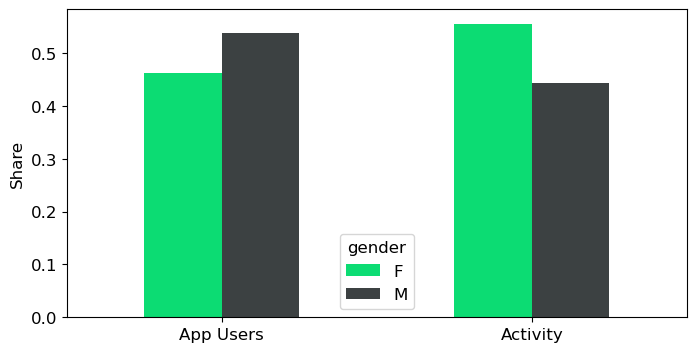

In [27]:
comparison = gender_dist_rel.merge(gender_dist_logs_rel, on='gender')
comparison.columns = ['App Users', 'Activity']

# Define plotting parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 12})

# Define colors to use throughout this notebook
colors = ["tealish green", "charcoal grey"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]

# Plot
comparison.transpose().plot.bar(rot = 0, color = [color1, color2]);
plt.ylabel('Share');

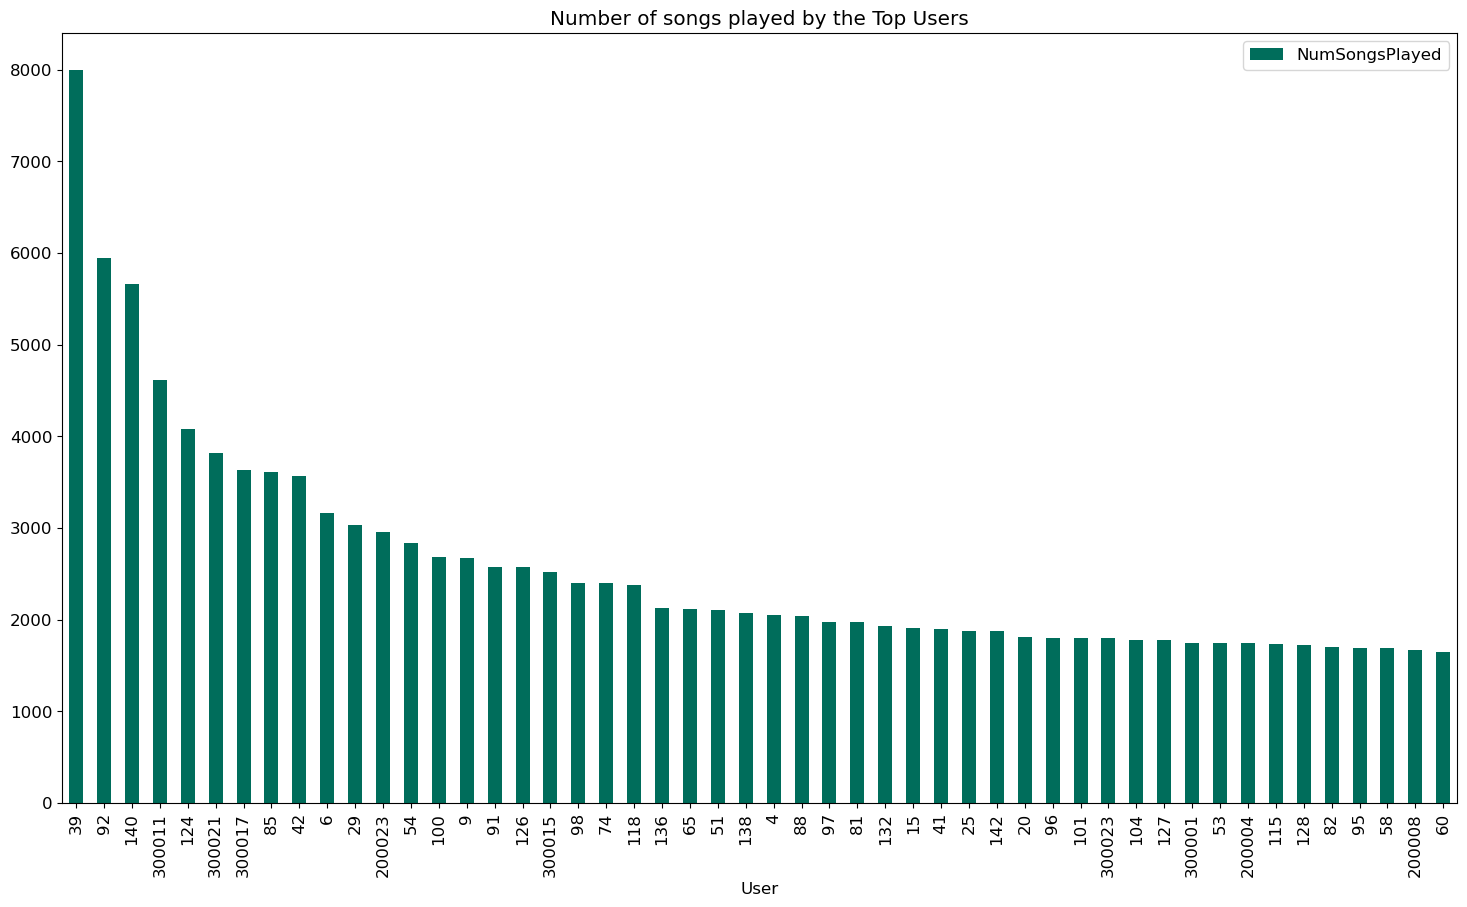

In [28]:
songs_df = df.filter(df.song != 'null').groupby('userId').agg(count(df.song).alias('NumSongsPlayed')).orderBy('NumSongsPlayed', ascending=False)
songs_df.toPandas().nlargest(50, 'NumSongsPlayed').plot(x='userId', kind='bar', color = '#006d5b', figsize=(18,10))
plt.xlabel('User')
plt.title('Number of songs played by the Top Users')
plt.show()

In [29]:
#Split the location column into two new columns - userCity, userState
split_columns = pyspark.sql.functions.split(df['location'], ',')
df = df.withColumn('userCity', split_columns.getItem(0))
df = df.withColumn('userState', split_columns.getItem(1))

#remove white space in userState
delete_space = udf(lambda s: s.replace(" ", ""), StringType())
df = df.withColumn("userCity", delete_space("userCity"))

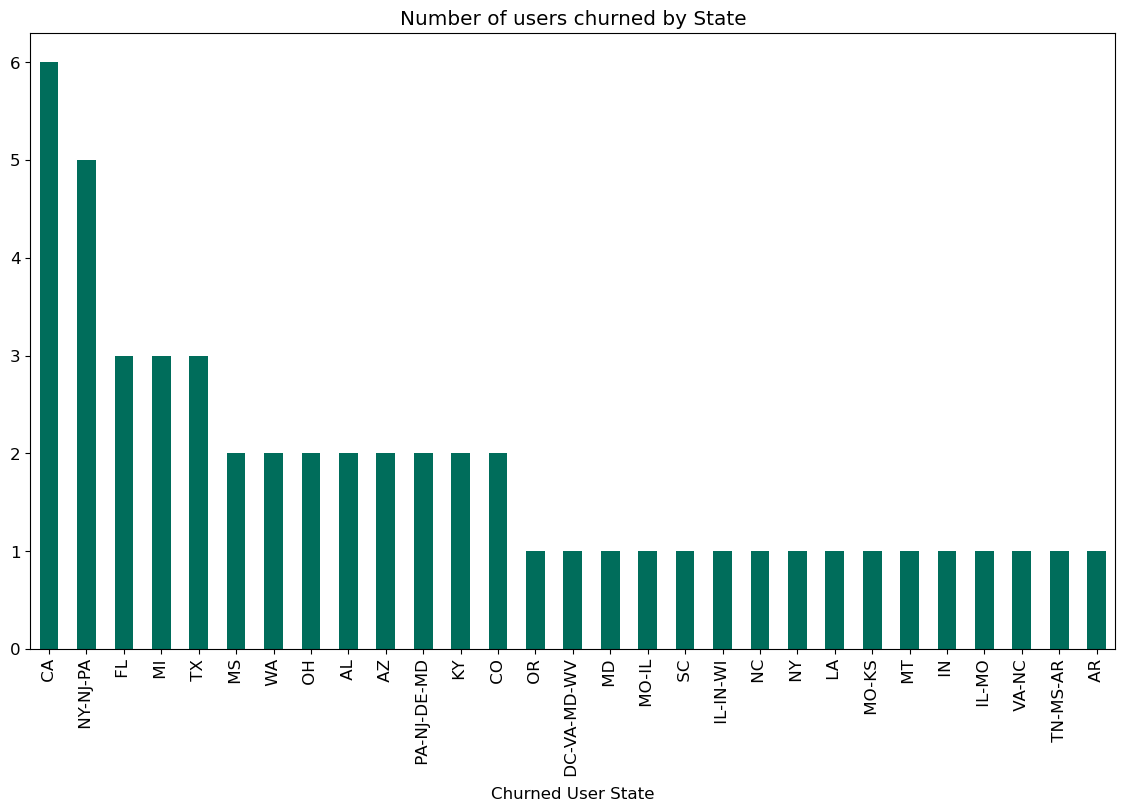

In [30]:
#filter data based on Cancellation Confirmation, gather unique userIds
churn_df = df.filter(df.page=="Cancellation Confirmation").select("userId","userState","level","gender").dropDuplicates()
churn_df.toPandas()['userState'].value_counts().plot(kind='bar',color = '#006d5b', figsize=(14,8))
plt.xlabel('Churned User State')
plt.title('Number of users churned by State')
plt.show()

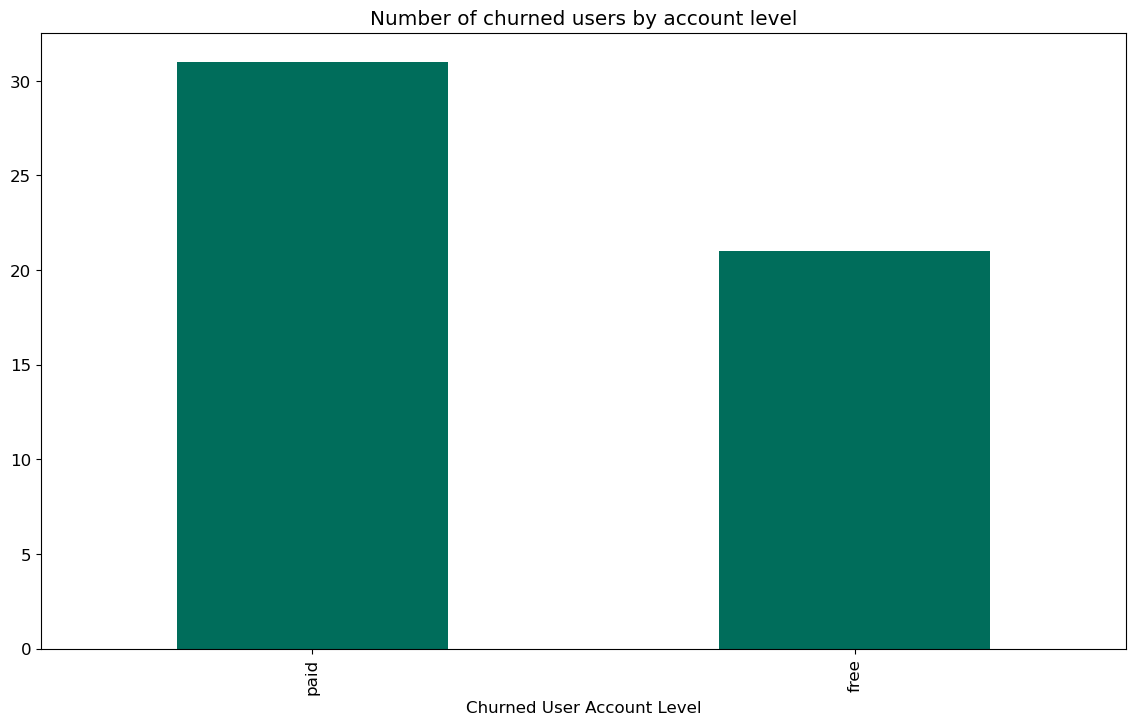

In [31]:
churn_df.toPandas()['level'].value_counts().plot(kind='bar',color = '#006d5b', figsize=(14,8))
plt.xlabel('Churned User Account Level')
plt.title('Number of churned users by account level')
plt.show()

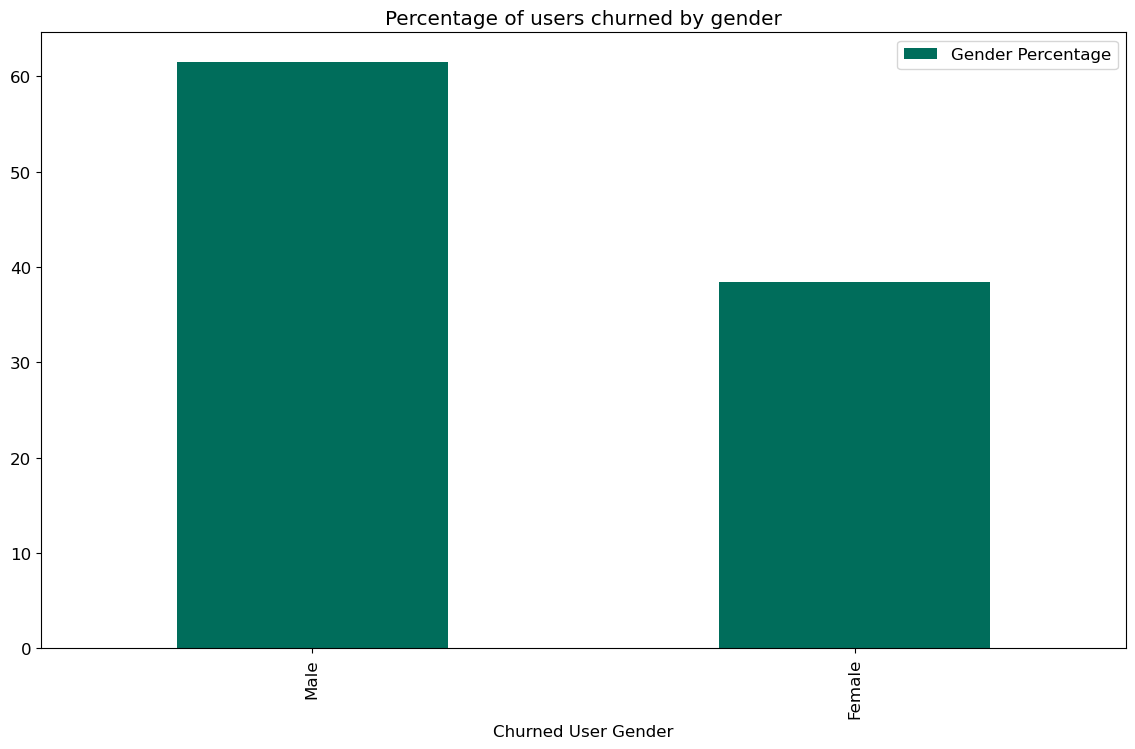

In [32]:
gender_m = churn_df.toPandas()['gender'].value_counts()[0]
gender_f = churn_df.toPandas()['gender'].value_counts()[1]
total_gender = gender_m + gender_f
gender_types = ['Male', 'Female']
gender_percentages = [(gender_m/total_gender)*100, (gender_f/total_gender)*100]
gender_percentages_df = pd.DataFrame(gender_percentages, columns=['Gender Percentage'], index=gender_types)
gender_percentages_df.plot(kind='bar',color= '#006d5b', figsize=(14,8))
plt.xlabel('Churned User Gender')
plt.title('Percentage of users churned by gender')
plt.show()

### Log Features Analysis

In [33]:
# Explore the 'page' column that represents the types of interactions with the music streaming service
# Obtain the distribution of the interaction types in the analyzed dataset
df.groupby('page').count().sort('count', ascending = False).show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



# 3. Transformation of Data
We had to convert the original dataset (one row per log) into a dataset with user-level information or statistics (one row per user), obtained either through mapping (e.g., user's gender, length of observation period, etc.) or aggregation (e.g., activity count), as both the predictors and the response variable need to be defined at the level of an individual user. 

### Time for registration and observation

In [37]:
# Convert the timestamps in columns 'registration' and 'ts' into datetime format and add them to the dataframe
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [38]:
# Based on the data shown below it seems the observation period started at 20:01:57, Septembre 30, 2018
df.select('userId', 'page', 'ts', 'tsDate').sort('ts').show(5)

+------+--------+-------------+-------------------+
|userId|    page|           ts|             tsDate|
+------+--------+-------------+-------------------+
|    30|NextSong|1538352117000|2018-09-30 20:01:57|
|     9|NextSong|1538352180000|2018-09-30 20:03:00|
|    30|NextSong|1538352394000|2018-09-30 20:06:34|
|     9|NextSong|1538352416000|2018-09-30 20:06:56|
|    30|NextSong|1538352676000|2018-09-30 20:11:16|
+------+--------+-------------+-------------------+
only showing top 5 rows



In [39]:
# Based on the data shown below it seems the observation period ended at 20:11:16, December 02, 2018 
df.select('userId', 'page', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

+------+---------------+-------------+-------------------+
|userId|           page|           ts|             tsDate|
+------+---------------+-------------+-------------------+
|100002|       NextSong|1543799476000|2018-12-02 20:11:16|
|200008|       NextSong|1543622579000|2018-11-30 19:02:59|
|   152|       NextSong|1543622432000|2018-11-30 19:00:32|
|300011|       NextSong|1543622411000|2018-11-30 19:00:11|
|300011|          About|1543622398000|2018-11-30 18:59:58|
|200008|       NextSong|1543622395000|2018-11-30 18:59:55|
|   138|       NextSong|1543622365000|2018-11-30 18:59:25|
|    39|       NextSong|1543622355000|2018-11-30 18:59:15|
|    30|Add to Playlist|1543622320000|2018-11-30 18:58:40|
|    30|       NextSong|1543622287000|2018-11-30 18:58:07|
+------+---------------+-------------+-------------------+
only showing top 10 rows



In [40]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column
df.where(df.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

+------+-------------------+---------+---------+--------------------+
|userId|             tsDate|sessionId|     auth|                page|
+------+-------------------+---------+---------+--------------------+
|    18|2018-10-07 16:26:30|      514|Cancelled|Cancellation Conf...|
|    32|2018-10-08 17:10:46|      540|Cancelled|Cancellation Conf...|
|   125|2018-10-12 00:35:18|      174|Cancelled|Cancellation Conf...|
|   105|2018-10-12 16:17:21|      508|Cancelled|Cancellation Conf...|
|    17|2018-10-13 17:19:44|      797|Cancelled|Cancellation Conf...|
+------+-------------------+---------+---------+--------------------+
only showing top 5 rows



In [41]:
# Remove rows with missing userId 
df = df.where(df.userId != "")
df.count()

278154

## Transformations on the Original Dataset

In [42]:
# Default observation start and end timestamps for users who have registered before October 1 and haven't churned
obs_start_default = 1538352000000
obs_end_default = 1543622400000

In [43]:
# "Submit registration" events have empty strings in the userId column.
# The userId can be inferred from the sessionId information.
df.select(['userId','auth','page','tsDate','sessionId']).where(df.page == 'Submit Registration').show()

+------+----+----+------+---------+
|userId|auth|page|tsDate|sessionId|
+------+----+----+------+---------+
+------+----+----+------+---------+



In [44]:
# Registration of the userId=154 - note that the time of "Submit Registration" log does not match the 
# registration time printed above.
df.select(['userId','auth','page','tsDate', 'sessionId']).where(df.sessionId == 1506).show(10)

+------+---------+---------------+-------------------+---------+
|userId|     auth|           page|             tsDate|sessionId|
+------+---------+---------------+-------------------+---------+
|   154|Logged In|           Home|2018-11-02 11:15:35|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:15:38|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:18:39|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:22:19|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:26:59|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:32:26|     1506|
|   154|Logged In|    Roll Advert|2018-11-02 11:33:03|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:36:29|     1506|
|   154|Logged In|       NextSong|2018-11-02 11:40:35|     1506|
|   154|Logged In|Add to Playlist|2018-11-02 11:40:46|     1506|
+------+---------+---------------+-------------------+---------+
only showing top 10 rows



In [45]:
# Lag the page column
windowsession = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn("lagged_page", lag(df.page).over(windowsession))

In [46]:
# With the lagged page column we can identify the users that registered later
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate', 'sessionId']).show()

+------+----+-----------+------+---------+
|userId|auth|lagged_page|tsDate|sessionId|
+------+----+-----------+------+---------+
+------+----+-----------+------+---------+



In [47]:
# All the values calculated here are the same for all logs belonging to a given user. Nevertheless, we attach them to the
# original dataset, as they are needed for activity trend calculation 
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Identify users that registered after the start of observation, and infer the start date accordingly
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", 
                   when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

In [48]:
# Identify users that cancelled their service, i.e. users whose last log event is "Cancellation Confirmation", and
# obtain the corresponding end of the observation period. This is done on the original dataset
# so a single value, e.g. end of observation period, is copied to all rows belonging to a given userId.

df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))


In [49]:
# For each log compute the time from the beginning of observation
df = df.withColumn("timefromstart", col('ts')-col("obsstart"))
#and time before the end of observation
df = df.withColumn("timebeforeend", col('obsend')-col('ts'))

In [50]:
# Example of a user with default observation start and earlier observation end due to Cancellation Confirmation
df.select(['userId','obsstart','obsend','endstate','page','ts','timefromstart','timebeforeend'])\
.where(df.userId == 100023).show(5)

+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|            endstate|      page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|100023|1538352000000|1539475237000|Cancellation Conf...|     About|1538665362000|    313362000|    809875000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538665432000|    313432000|    809805000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665433000|    313433000|    809804000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665434000|    313434000|    809803000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538767734000|    415734000|    707503000|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
o

#### Last Subscription Level
Finding the user's last subscription level (free or paid) at the last log entry, or the user's subscription level at the conclusion of the default observation period, is another operation we carried out on the original dataset. 

In [51]:
# Obtain user's last subscription level and add it to the original dataset
df = df.withColumn("lastlevel", last(col('level')).over(windowuser))

In [52]:
# Remove rows with corrupted timestamps
df = df.where(df.ts < obs_end_default)
df.count()

278150

### Mapping and Aggregation
Next, we converted the original Sparkify dataset (one row per log) into a dataset with user-level data or statistics (one row per user). The data was obtained either through mapping from the original dataset (applies to user-level features like user's gender, last subscription level, etc.) or aggregation (grouping the logs by userId, e.g. total activity count of each user).
The newly created dataset includes the following columns:

userId
* lastlevel : user's last subscription level, transformed into binary format (1 - paid tier, 0 - free tier)
* gender : gender, transformed into binary format (1 - female, 0 - male)
* obsstart, obsend: start and end of the observation period
* endstate : last interaction in the observation period
* nact : user's total number of interactions in the observation period
* nsongs, ntbup, ntbdown, nfriend, nplaylist, ndgrade, nupgrade, nhome, nadvert, nhelp, nsettings, nerror : number of songs played, thumbs up given, thumbs down given, friends added, songs added to playlist, downgrades, upgrades, home page visits, advertisements played, help page visits, settings visits, errors, respectively
* nact_recent, nact_oldest : user's activity in the last and first k days of the observation window, respectively
* nsongs_recent, nsongs_oldest : songs played in the last and first k days of the observation window, respectively

In [53]:
# Length of the estimation window for activity trend calculation
trend_est_days = 14
trend_est_hours = trend_est_days * 24
# In timestamp format
trend_est = trend_est_days * 24 * 60 * 60 * 1000

In [54]:
# Aggregation by userId
df_user = df.groupby('userId')\
.agg(
     # User-level features
     first(when(col('lastlevel') == 'paid', 1).otherwise(0)).alias('lastlevel'),
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     first(col('obsstart')).alias('obsstart'),
     first(col('obsend')).alias('obsend'),
     first(col('endstate')).alias('endstate'),
     
     # Aggregated activity statistics
     count(col('page')).alias('nact'),
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsongs"),
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("nsettings"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror"),
     
     # Aggregated activity statistics in different periods 
     Fsum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias("nact_recent"),
     Fsum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias("nact_oldest"),
     Fsum(when((col('page') == "NextSong") & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias("nsongs_recent"),
     Fsum(when((col('page') == "NextSong") & (col('timefromstart') < trend_est), 1).otherwise(0)).alias("nsongs_oldest") )

In [55]:
# Sample rows in a newly created dataset; user-level features
df_user.select(['userId','gender','lastlevel','obsstart','obsend','endstate']).show(5)

+------+------+---------+-------------+-------------+--------------------+
|userId|gender|lastlevel|     obsstart|       obsend|            endstate|
+------+------+---------+-------------+-------------+--------------------+
|100010|     1|        0|1538352000000|1543622400000|              Logout|
|100014|     0|        1|1538352000000|1542740649000|Cancellation Conf...|
|100021|     0|        0|1538352000000|1543143782000|Cancellation Conf...|
|100022|     1|        0|1538352000000|1542038645000|Cancellation Conf...|
|   101|     0|        1|1538352000000|1539729037000|Cancellation Conf...|
+------+------+---------+-------------+-------------+--------------------+
only showing top 5 rows



### Categorical Features
In addition to all the above-defined features, we have decided to use two **categorical** user-level features in the model: user's ***gender*** and user's last subscription level stored in the ***lastlevel*** variable. Both have been obtained already in the step above, so no further data transformations were needed.

In [56]:
# Calculation of the defined features that will be used for identifying churned users

df_user = df_user.withColumn('obshours', (col('obsend') - col('obsstart'))/1000/3600)\
.withColumn('nact_perh', col('nact') / col('obshours'))\
.withColumn('nsongs_perh', col('nsongs') / col('obshours'))\
.withColumn('ntbup_perh', col('ntbup') / col('obshours'))\
.withColumn('ntbdown_perh', col('ntbdown') / col('obshours'))\
.withColumn('nfriend_perh', col('nfriend') / col('obshours'))\
.withColumn('nplaylist_perh', col('nplaylist') / col('obshours'))\
.withColumn('nhome_perh', col('nhome') / col('obshours'))\
.withColumn('nadvert_perh', col('nadvert') / col('obshours'))\
.withColumn('nerror_perh', col('nerror') / col('obshours'))\
.withColumn('upgradedowngrade', col('nugrade') + col('ndgrade'))\
.withColumn('songratio', col('nsongs') / col('nact'))\
.withColumn('positiveratio', (col('ntbup') + col('nfriend') + col('nplaylist')) / col('nact'))\
.withColumn('negativeratio', (col('ntbdown') + col('nhelp') + col('nerror') + col('nsettings')) / col('nact'))\
.withColumn('updownratio', col('ntbup') / (col('ntbdown') + 0.1))\
.withColumn('nact_recent_perh', col('nact_recent') / trend_est_hours)\
.withColumn('nact_oldest_perh', col('nact_oldest') / trend_est_hours)\
.withColumn('nsongs_recent_perh', col('nsongs_recent') / trend_est_hours)\
.withColumn('nsongs_oldest_perh', col('nsongs_oldest') / trend_est_hours)\
.withColumn('trend_act', (col('nact_recent_perh') - col('nact_oldest_perh')) / col('obshours'))\
.withColumn('trend_songs', (col('nsongs_recent_perh') - col('nsongs_oldest_perh')) / col('obshours'))

In [57]:
# Engineered features - aggregated statistics per hour
df_user.select(['userId','nact_perh','nsongs_perh', 'ntbup_perh','ntbdown_perh','nfriend_perh']).show(5)

+------+-------------------+-------------------+--------------------+--------------------+--------------------+
|userId|          nact_perh|        nsongs_perh|          ntbup_perh|        ntbdown_perh|        nfriend_perh|
+------+-------------------+-------------------+--------------------+--------------------+--------------------+
|100008| 0.6420765027322405| 0.5273224043715847|0.025273224043715847|0.004098360655737705|0.011612021857923498|
|100010|0.26024590163934425| 0.1878415300546448|0.011612021857923498|0.003415300546448...| 0.00273224043715847|
|100014|0.25429238018351435| 0.2108165861521393| 0.01394506601006369|0.002460894001775945| 0.00492178800355189|
|100021|0.23966031843685712|0.17279584087923866|0.008264148911615763|0.003756431323461...|0.005259003852846394|
|100022| 0.9413436878245669|  0.664994866606359| 0.04394239206649949| 0.01952995202955533|0.010741473616255432|
+------+-------------------+-------------------+--------------------+--------------------+--------------

In [58]:
# Engineered features - activity type ratios
df_user.select(['userId', 'upgradedowngrade', 'songratio', 'positiveratio', 'negativeratio', 'updownratio']).show(5)

+------+----------------+------------------+-------------------+--------------------+-----------------+
|userId|upgradedowngrade|         songratio|      positiveratio|       negativeratio|      updownratio|
+------+----------------+------------------+-------------------+--------------------+-----------------+
|    51|               0| 0.856737012987013|0.07305194805194805|0.018668831168831168|4.739336492890995|
|   124|               0|0.8453886010362694|0.07523316062176166| 0.01865284974093264|4.160583941605839|
|     7|               0| 0.746268656716418|0.06467661691542288|0.029850746268656716|6.363636363636363|
|    54|               2| 0.826592958975851|0.07797497817864417| 0.01862089031131801|5.601374570446735|
|    15|               0|0.8402107111501317|0.07506584723441616| 0.01755926251097454| 5.74468085106383|
+------+----------------+------------------+-------------------+--------------------+-----------------+
only showing top 5 rows



In [59]:
# Engineered features - trend features
df_user.select(['userId', 'trend_act', 'trend_songs']).show(5)

+------+--------------------+--------------------+
|userId|           trend_act|         trend_songs|
+------+--------------------+--------------------+
|100008|0.001012392661982826|8.314630497007545E-4|
|100010|-1.42304189435336...|-1.42304189435337...|
|100014|-2.92963571639993...|-4.63858988429989...|
|100021|1.878215661730854...|1.498100587332944E-4|
|100022|-1.71468328830917...|-1.36593414492425...|
+------+--------------------+--------------------+
only showing top 5 rows



In [60]:
# Calculation of user's average number of items per session
session_avgnitems = df.groupby(['userId', 'sessionId'])\
.agg(Fmax(col('itemInSession')).alias('nitems'))\
.groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))


# Calculation of user's average session length
session_avglength = df.groupby(['userId', 'sessionId'])\
.agg(Fmin(col('ts')).alias('startsession'), Fmax(col('ts')).alias('endsession'))\
.groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessionlength'))


# Calculations to obtain user's average number of songs played between consecutive home visits
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0))
df = df.withColumn("phasehome", Fsum(when(df.page == "Home", 1).otherwise(0)).over(windowhome))

songs_home = df.groupby(['userId', 'phasehome'])\
.agg(Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias('total'))\
.groupby('userId').agg(avg(col('total')).alias('avgsongs'))


# Adding the extra features to the df_user dataset with all other engineered features
df_user = df_user\
.join(session_avgnitems, on = 'userId')\
.join(session_avglength, on = 'userId')\
.join(songs_home, on = 'userId')


# Engineered features - user's activity patterns
df_user.select(['userId', 'avgsessionitems', 'avgsessionlength', 'avgsongs']).show(5)

+------+------------------+--------------------+------------------+
|userId|   avgsessionitems|    avgsessionlength|          avgsongs|
+------+------------------+--------------------+------------------+
|100010| 54.42857142857143|           9269000.0|22.916666666666668|
|200002|              80.0|            1.5984E7|18.428571428571427|
|   125|              10.0|           1774000.0|               8.0|
|    51|             251.9|           5.23414E7| 28.14666666666667|
|   124|170.13793103448276|3.4739655172413796E7|23.176136363636363|
+------+------------------+--------------------+------------------+
only showing top 5 rows



### Defining Churn
label : binary response variable, where:

* 1 represents churned users who cancelled the subscription (irrespective of the subscription plan, free or paid) within the observation period between October 1 and November 30;
* 0 represents users who kept the music streaming service throughout the observation period

In [61]:
# Calculating the binary response variable
df_user = df_user.withColumn('label', when(df_user.endstate == "Cancellation Confirmation", 1).otherwise(0))

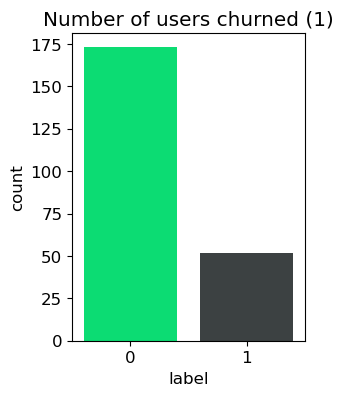

In [62]:
# Distribution of the binary response variable in the analyzed dataset
label_pd = df_user.groupby('label').count().toPandas()

# Plot
plt.rcParams['figure.figsize'] = (3,4)
sns.barplot(x='label', y = 'count', data = label_pd, palette = palette, saturation = 1);
plt.title('Number of users churned (1)');

In [64]:
# Final schema of the transformed dataset
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lastlevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- obsstart: long (nullable = true)
 |-- obsend: long (nullable = true)
 |-- endstate: string (nullable = true)
 |-- nact: long (nullable = false)
 |-- nsongs: long (nullable = true)
 |-- ntbup: long (nullable = true)
 |-- ntbdown: long (nullable = true)
 |-- nfriend: long (nullable = true)
 |-- nplaylist: long (nullable = true)
 |-- ndgrade: long (nullable = true)
 |-- nugrade: long (nullable = true)
 |-- nhome: long (nullable = true)
 |-- nadvert: long (nullable = true)
 |-- nhelp: long (nullable = true)
 |-- nsettings: long (nullable = true)
 |-- nerror: long (nullable = true)
 |-- nact_recent: long (nullable = true)
 |-- nact_oldest: long (nullable = true)
 |-- nsongs_recent: long (nullable = true)
 |-- nsongs_oldest: long (nullable = true)
 |-- obshours: double (nullable = true)
 |-- nact_perh: double (nullable = true)
 |-- nsongs_perh: double (nullable = t

# 5. Exploratory Data Analysis
After completing the feature engineering step we have analyzed the correlations between the built features, and performed also a brief exploratory data analysis with visualizations to inspect how the features relate to the binary response.

In [65]:
# For visualization purposes we switch to pandas dataframes
df_user_pd = df_user.toPandas()

23/06/09 16:52:57 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


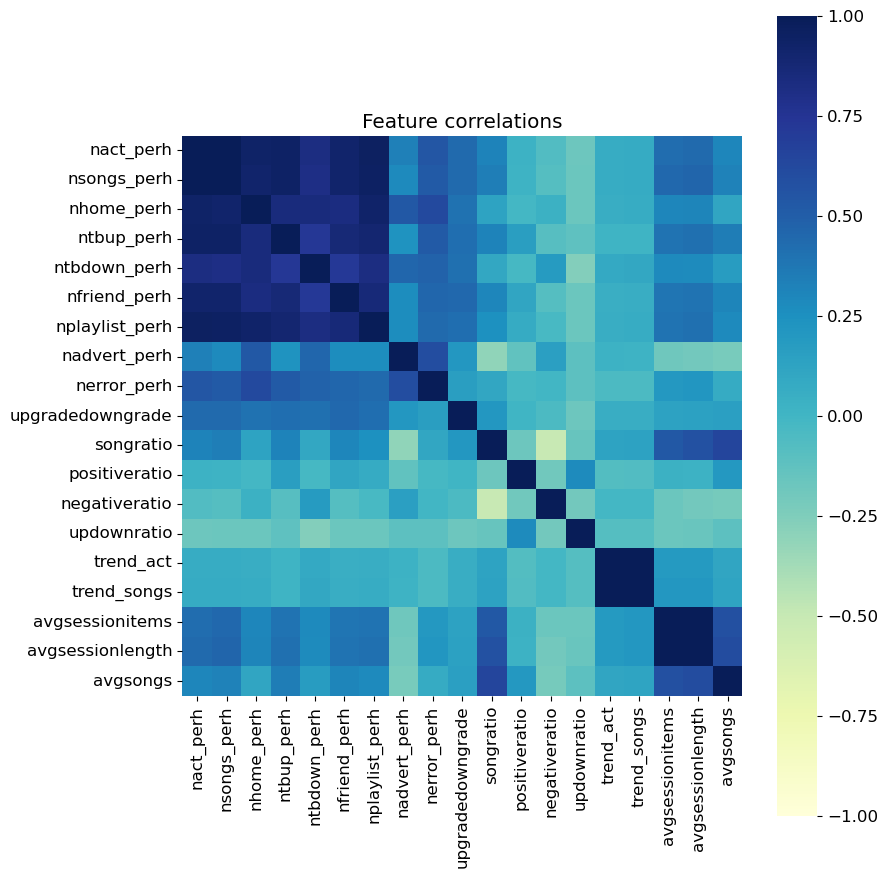

In [66]:
# Calculate correlations between numerical features
cormat = df_user_pd[['nact_perh','nsongs_perh', 'nhome_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_act', 'trend_songs', 'avgsessionitems',  'avgsessionlength','avgsongs']].corr()

# Plot correlations
plt.rcParams['figure.figsize'] = (10,10)
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.heatmap(cormat, cmap = "YlGnBu", square = True, vmin = -1, vmax = 1);
plt.title('Feature correlations');
plt.savefig('correlations.png')

#### Result from Exploratory Data Analysis
For each engineered feature (except the ones removed in the step above) we have analyzed its relationship with the binary response variable. This was done by comparing the feature distributions between users who churned and users who kept the service. From the visualizations presented below the following _stylized_ observations have been made:
- on average churned users played more songs per hour;
- churned users gave significantly more thumbs down per hour, and had to watch more advertisements on average;
- the ratio of songs and positive interactions relative to total activity was typically lower for churned users
- churned users had on average less interactions per session
- churn rate is higher for users in the free subscription plan
- churn rate is slightly higher for male users
 


/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/mohil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

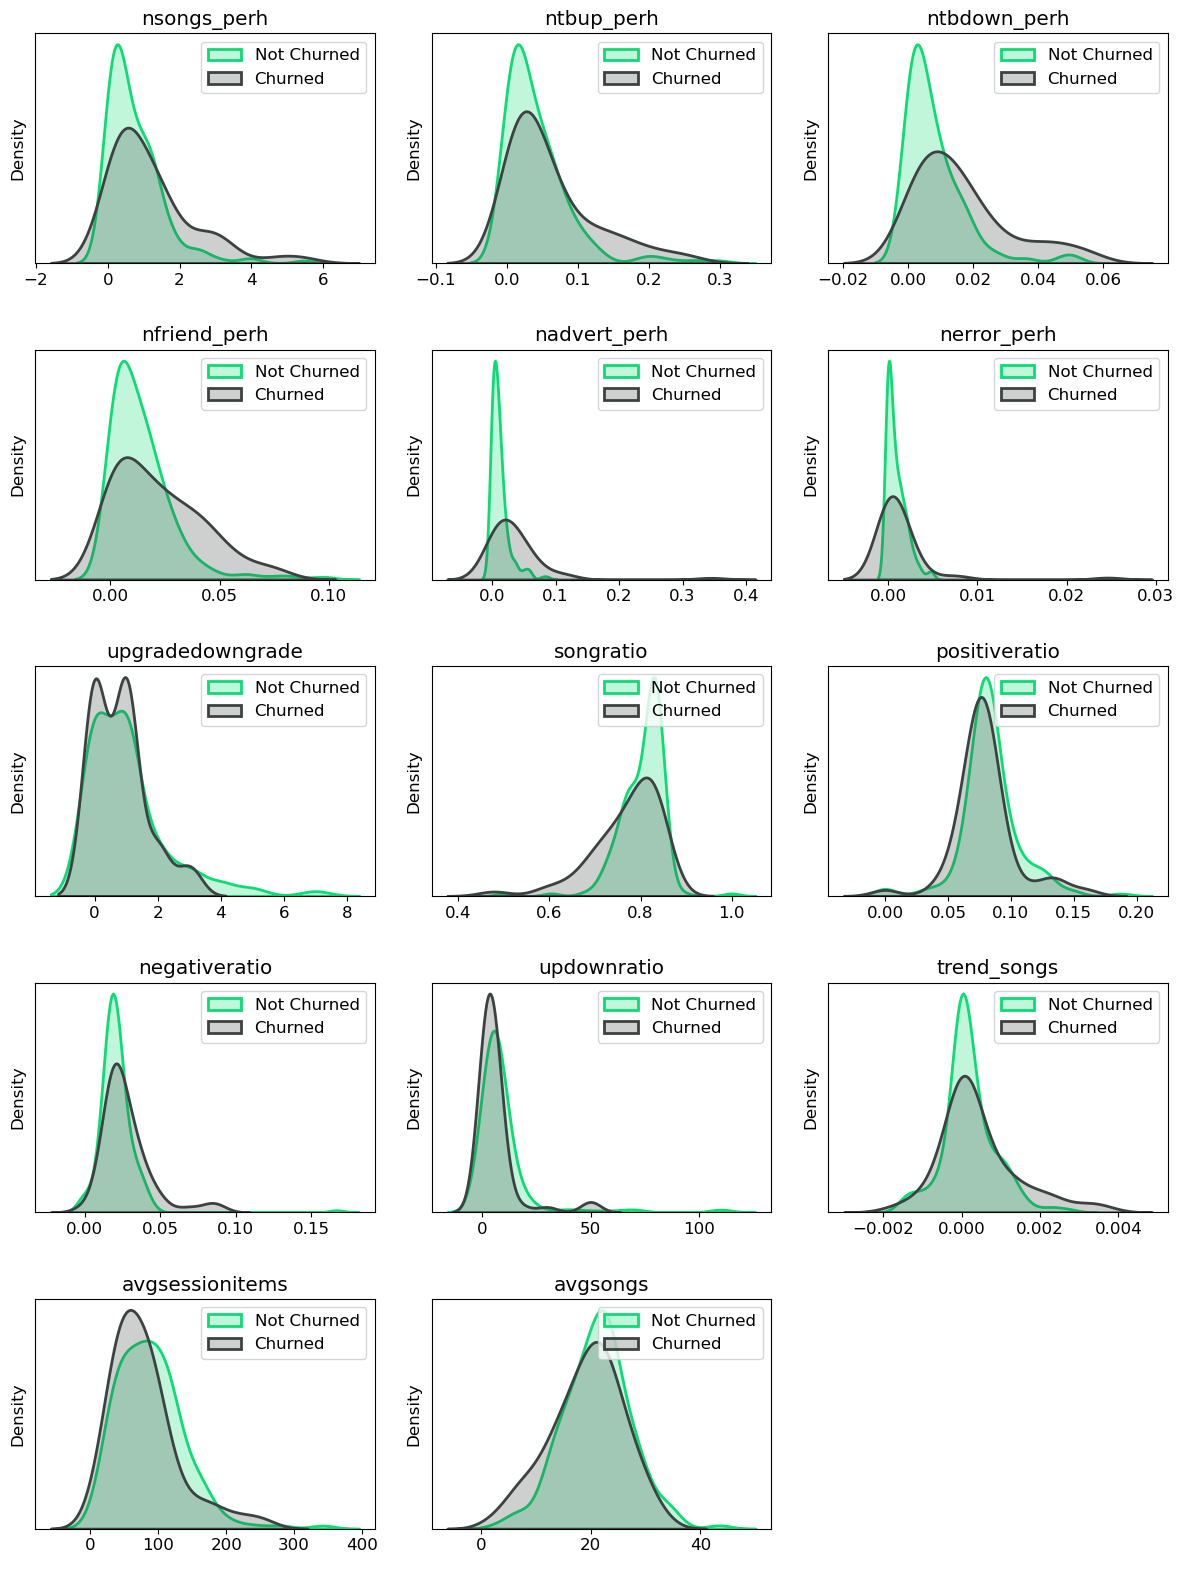

In [67]:
# Plotting the relationship between each numerical feature and binary response

# Numerical features
col = ['nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
       'nfriend_perh', 'nadvert_perh', 'nerror_perh',
       'upgradedowngrade', 'songratio', 'positiveratio',
       'negativeratio', 'updownratio', 'trend_songs', 
       'avgsessionitems','avgsongs']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(col)):
    plt.subplot(5,3,i+1)
    plt.tight_layout();
    sns.distplot(df_user_pd[df_user_pd['label'] == 0][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color1);
    sns.distplot(df_user_pd[df_user_pd['label'] == 1][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color2);
    plt.legend(['Not Churned','Churned']);
    plt.title(col[i]);
    plt.xlabel(" ");
    plt.yticks([]);
    plt.savefig('exploratory.png')

# 6. Modeling and Evaluation


In [68]:
numeric_columns = ['nsongs_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_songs', 'avgsessionitems','avgsongs']

# Combining multiple numerical features using VectorAssembler
numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

# Standardizing numerical features
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)

# Adding the two binary features
binary_columns = ['lastlevel', 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")

# Defining three different pipelines with three different classifiers, all with default parameters
# Logistic regression 
lr =  LogisticRegression()
pipeline_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, lr])

# Random forest classifier
rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, rf])

# Gradient-boosted tree classifier
gb = GBTClassifier()
pipeline_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, gb])

In [69]:
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon to prevent division by zero
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

In [70]:
# Logistic regression grid search

# Parameter combinations
paramGrid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10, 30]) \
.addGrid(lr.regParam, [0.0, 0.1]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5]) \
.build()

# Grid search with cross validation
crossval_lr = CrossValidator(estimator = pipeline_lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [71]:
# Random forest classifier grid search

# Parameter combinations
paramGrid_rf = ParamGridBuilder() \
.addGrid(rf.maxDepth, [4, 5, 6, 7]) \
.addGrid(rf.numTrees, [20, 40]) \
.build()

# Grid search with cross validation
crossval_rf = CrossValidator(estimator = pipeline_rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [72]:
# Gradient-boosted tree classifier grid search

# Parameter combinations
paramGrid_gb = ParamGridBuilder() \
.addGrid(gb.maxDepth, [4, 5]) \
.addGrid(gb.maxIter, [20, 100]) \
.build()

# Grid search with cross validation
crossval_gb = CrossValidator(estimator = pipeline_gb,
                          estimatorParamMaps = paramGrid_gb,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

## Training/Test Data Split
The input dataset has been split into training and test set using the **80/20** ratio. During the model tuning the training set is used in 4-fold cross validation so it is further split into multiple training and validation folds.

In [73]:
# Split the data into training (plus validation) and test set 

train_plus_val, test = df_user.randomSplit([0.8, 0.2], seed = 9) 
ntotal = df_user.count()
ntrainval = train_plus_val.count()
ntest = test.count()

print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

Original dataset: 225 rows. Training and validation: 174 rows. Testing set: 51 rows


### Logistic Regression

In [74]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_lr = crossval_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

# Store grid search results in a dataframe
scores = crossvalmodel_lr.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC score'] = scores
params_pd

23/06/09 16:53:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Time spent for grid search: 612 seconds


,maxIter,regParam,elasticNetParam,AUC score
0,10,0.0,0.0,0.771260
1,10,0.0,0.5,0.771260
2,10,0.1,0.0,0.792197
3,10,0.1,0.5,0.763187
4,30,0.0,0.0,0.755810
5,30,0.0,0.5,0.755810
6,30,0.1,0.0,0.792197
7,30,0.1,0.5,0.762646


In [75]:
# Retrain the classifier with the best performing parameters
best_lr =  LogisticRegression(maxIter = 10, regParam = 0.0)
pipeline_best_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_lr])

start = time.time()
model_lr = pipeline_best_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 28 seconds


In [76]:
# Obtain predictions on the test set
results_lr = model_lr.transform(test)
results_lr.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   101|    1|[-0.1526538960799...|[0.46191046464440...|       1.0|
|   132|    0|[2.91998312030549...|[0.94882547948392...|       0.0|
|   133|    0|[1.85548022586251...|[0.86476926123831...|       0.0|
|    28|    1|[-1.6754896879742...|[0.15769363264895...|       1.0|
|    34|    0|[1.05571808230859...|[0.74187141529596...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [77]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_lr = f1_evaluator._evaluate(results_lr)
print(f'Logistic regression F1 score: {f1score_lr}')

Logistic regression F1 score: 0.6999943500356034


### Random Forest Classifier

In [78]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_rf = crossval_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 629 seconds


In [79]:
# Store grid search results in a dataframe
scores = crossvalmodel_rf.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,numTrees,score
0,4,20,0.791320
1,4,40,0.838755
2,5,20,0.805997
3,5,40,0.843033
4,6,20,0.785156
5,6,40,0.850951
6,7,20,0.792005
7,7,40,0.850019


In [80]:
# Retrain the classifier with the best performing parameters
best_rf =  RandomForestClassifier(maxDepth = 4, numTrees = 40)
pipeline_best_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_rf])

start = time.time()
model_rf = pipeline_best_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 37 seconds


In [81]:
# Display feature importances
importances = model_rf.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
6,nadvert_perh,0.187188
9,songratio,0.108016
12,updownratio,0.107798
4,ntbdown_perh,0.107505
5,nfriend_perh,0.086288
2,nsongs_perh,0.075513
15,avgsongs,0.058223
11,negativeratio,0.054158
13,trend_songs,0.054001
14,avgsessionitems,0.042763


In [82]:
# Obtain predictions on the test set
results_rf = model_rf.transform(test)

In [83]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_rf = f1_evaluator._evaluate(results_rf)
print(f'Random forest classifier F1 score: {f1score_rf}')

Random forest classifier F1 score: 0.4705831142308158


### Gradient-boosted Tree Classifier

In [84]:
# Perform the grid search by fitting the grid search object
start = time.time()

crossvalmodel_gb = crossval_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

23/06/09 17:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1000.2 KiB


Time spent for grid search: 4745 seconds


In [85]:
# Store grid search results in a dataframe
scores = crossvalmodel_gb.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,maxIter,score
0,4,20,0.737795
1,4,100,0.740967
2,5,20,0.750677
3,5,100,0.758777


In [86]:
# Retrain the classifier with the best performing parameters
best_gb =  GBTClassifier(maxDepth = 5, maxIter = 100)
pipeline_best_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_gb])

start = time.time()
model_gb = pipeline_best_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 55 seconds


In [87]:
# Display feature importances
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
5,nfriend_perh,0.199850
6,nadvert_perh,0.128363
2,nsongs_perh,0.118232
9,songratio,0.073505
11,negativeratio,0.073313
10,positiveratio,0.073208
12,updownratio,0.063551
7,nerror_perh,0.063484
4,ntbdown_perh,0.063281
13,trend_songs,0.044389


In [88]:
# Obtain predictions on the test set
results_gb = model_gb.transform(test)
results_gb.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   101|    1|[-1.3025701355544...|[0.06880833302363...|       1.0|
|   132|    0|[1.69340927188126...|[0.96729003284970...|       0.0|
|   133|    0|[2.07055519929617...|[0.98434383354967...|       0.0|
|    28|    1|[0.64429566754021...|[0.78390866258995...|       0.0|
|    34|    0|[0.11502831118274...|[0.55726182457520...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [89]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_gb = f1_evaluator._evaluate(results_gb)
print(f'Gradient-boosted tree classifier F1 score: {f1score_gb}')

Gradient-boosted tree classifier F1 score: 0.6315734072402873


## Results Summary

We have ultimately trained and tested three different models, one per each classifier type. The results obtained on the test set are summarized in the table below.

|Classifier                        |  F1   |
| :------------------------------- |-------|
|Logistic Regression               | 0.699 |
|Random Forest Classifier          | 0.470 |
|Gradient-boosted Tree Classifier  | 0.631 |

The F1 scores show a significantly weaker performance, with only the Logistic Regression approach scoring a solid 0.699.  The above F1 scores have been obtained using the default 0.5 threshold.

It is important to note that these outcomes are consistent with models that were developed and evaluated using the Sparkify dataset, which includes a smaller total of only 225 unique users. Accordingly, the models are evaluated on a sample of 46 occurrences, of which only 10 (on average) are positive classes. This results in fairly erratic performance evaluation findings for the models.




## Feature Importances

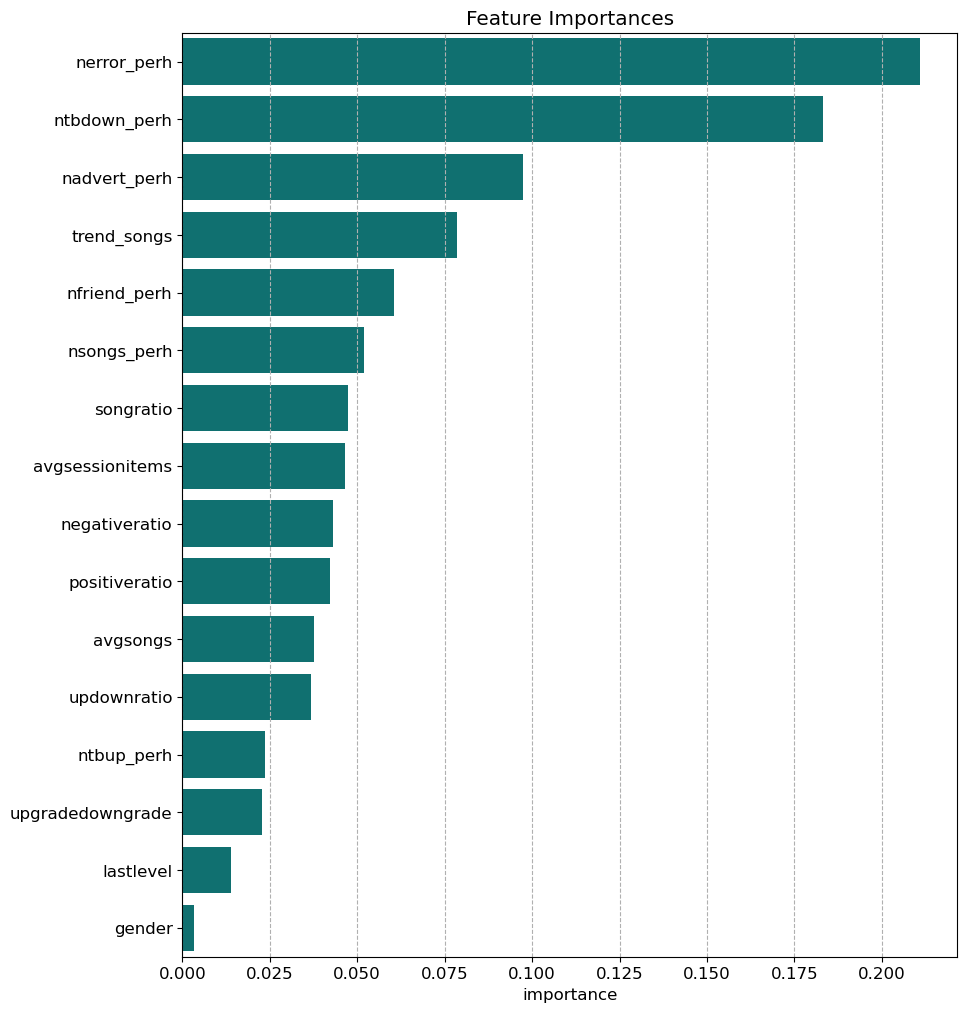

In [90]:
# Plot horizontal bar graph of features with their importances given by best estimator of RandomForestClassifier
fig, ax = plt.subplots(figsize=(10, 12),
                       nrows=1,
                       ncols=1)
features = ['lastlevel', 'gender', 'nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
            'nfriend_perh', 'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 
            'songratio', 'positiveratio', 'negativeratio', 'updownratio', 
            'trend_songs', 'avgsessionitems', 'avgsongs']
importances = [0.013795342305289867, 0.003419130795754195, 0.05192724418392687, 
               0.023604481206826188, 0.18329355168409747, 0.060501586172062846, 0.0974098898402886,
               0.2110401549499677, 0.02286163968506689, 0.04730318423769473, 0.04232860002653574, 
               0.043054343894025765, 0.036773157537074976, 0.07858267078570629, 0.046534988450475566, 0.03757003424520641]
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# Plot
sns.barplot(data = feat_imp_pd, y = "feature", x ="importance",
           color='teal');
plt.grid(axis = 'x', linestyle = '--', zorder=0)
plt.title("Feature Importances")
plt.ylabel("");
plt.savefig('feature.png')

In [2]:
git init


SyntaxError: invalid syntax (3277417328.py, line 1)